## <center> **Анализ результатов A/B-тестирования**

Компания планирует запустить новую акцию, чтобы продать как можно больше туров. Команда разработала два варианта посадочной страницы официального сайта компании и провела A/B-тестирование. Собранные в результате проведения эксперимента данные вы можете найти здесь.

Вам предстоит решить настоящую бизнес-задачу: проанализировать эффективность обоих вариантов посадочной страницы сразу по двум критериям: конверсии покупки и среднему чеку. На основе проведенного анализа вам будет необходимо сделать выводы и принять решение: какой из вариантов дизайна более предпочтительный.

Итак, наша фирма предлагает следующие варианты туров и их соответствующие стоимости:
* Таиланд — 100000 рублей;
* Турция — 60000 рублей;
* Мальдивы — 200000 рублей;
* Санкт-Петербург — 10000 рублей;
* Камчатка — 150000 рублей.

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.stats import t
from scipy.stats import ttest_ind, shapiro, f_oneway, mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest

Прочитаем наши данные и посмотрим на столбцы таблицы:

In [26]:
data = pd.read_csv('data/ab_data_tourist.csv')
data.head()

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


## **Задание 7.1.**

Начнем с исследования структуры наших данных. С помощью метода info() выведите информацию о типах данных и количестве непустых значений. Какой тип данных имеет столбец date?

In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   294478 non-null  int64 
 1   date      294478 non-null  object
 2   group     294478 non-null  object
 3   purchase  294478 non-null  int64 
 4   price     294478 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 11.2+ MB


*Cтолбец date имеет тип данных object*

## **Задание 7.2.**

Приведите столбец date к типу данных datetime. Убедитесь в равной длительности проведения тестирования для каждой из группы. Для этого сгруппируйте данные по признаку группы и определите первую и последнюю дату наблюдения для каждой из групп. 

В какой промежуток времени проводился A/B-тест?


In [28]:
data.head()

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


In [29]:
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
data2= data.groupby('group')['date'].agg(['min', 'max'])
data2.head()

,min,max
group,,
A,2021-01-02,2021-01-24
B,2021-01-02,2021-01-24


*Тест проводился в период со 2 января 2021 г.  по 24 января 2021 г.*

## **Задание 7.3.**

* Чему равно количество посещений сайта в группах А и B?

* Чему равно суммарное количество покупок в группах А и B?

* Чему равна сумма всех покупок в группах А и B? Ответ приведите в миллионах рублей. Например, 185.52 млн. руб.

In [30]:
# сгруппируем данные по значению группы
data3 = data.groupby(['group']).agg({'user_id': 'count','purchase':'sum','price': 'sum'}).reset_index()
data3['price']=data3['price']/1000000
data3

,group,user_id,purchase,price
0,A,147202,17723,1436.26
1,B,147276,17514,1554.10


*Количество посещений сайта в группах А и В соответственно равно 147202 и 147276. суммарное количество покупок соответственно 17723 и 17514, сумма всех покупок соответственно 1436.26 млн.руб. и 1554.10 млн.руб.*

## **Задание 7.4.**

Проверьте, есть ли пользователи, которые в процессе A/B-теста попали в обе тестовые группы? Если да, то сколько таких уникальных пользователей, если нет - введите в поле для ответа 0?

**Подсказка:**

*Создайте множество пользователей группы А и множество пользователей группы B. Пересеките два этих множества (операция intersection) и вычислите количество элементов в полученном множестве.*


In [31]:
a_set =set(data[data['group'] == 'A']['user_id'].unique())
b_set =set(data[data['group'] == 'B']['user_id'].unique())
print (len(a_set), len(b_set))
user_intersection = a_set.intersection(b_set)
print (len(user_intersection))


146195 146284
1895


## **Исключите пользователей, оказавшихся в обеих группах**

Так как мы не можем определить, какая из версий сайта повлияла на принятие решения, исключим этих пользователей. Далее мы будем работать только с очищенными от пересечений данными.

Возможный вариант исключения пользователей:

In [32]:
updated_data = data[data['user_id'].apply(lambda x: x not in user_intersection)]
updated_data.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290688 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   user_id   290688 non-null  int64         
 1   date      290688 non-null  datetime64[ns]
 2   group     290688 non-null  object        
 3   purchase  290688 non-null  int64         
 4   price     290688 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 13.3+ MB


Где user_intersection - множество пересечений пользователей групп А и B.

## **Задание 7.5.**

Для первичного анализа результатов A/B-тестирования нам понадобится таблица следующего вида:

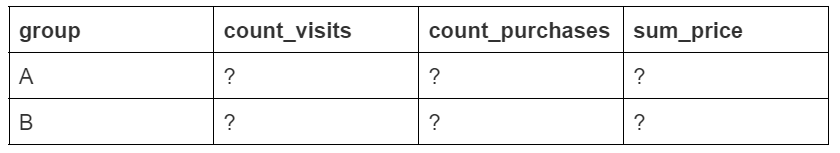
 
 
Для того, чтобы получить такую таблицу, сгруппируйте данные по признаку группы. В каждой группе рассчитайте следующие показатели:
* количество посещений (количество пользователей)
* количество совершенных покупок
* сумма всех покупок в группе

В полученной сгруппированной таблице переименуйте столбцы на **count_visits, count_purchases и sum_price**.

**Подсказка:**

*Для переименования столбцов можно использовать метод rename() с параметром columns, в который передается словарь. Ключи этого словаря - старые имена столбцов, а значения - новые.*

Чему на этот раз равно количество посещений сайта в группах А и B?


In [33]:
# получение сгруппированной таблицы с переименованием столбцов
rename_col = {'user_id': 'count_visits', 'purchase': 'count_purchases', 'price': 'sum_price'}
updated_data2 = updated_data.groupby('group').agg({
    'user_id':'count',
    'purchase':'sum',
    'price':'sum'   
}).reset_index().rename(columns=rename_col)
updated_data2.head()

,group,count_visits,count_purchases,sum_price
0,A,145307,17487,1417780000
1,B,145381,17290,1533010000


Приведите промежуточные выводы по построенной таблице. Сопоставимо ли количество посещений обоих вариантов посадочной странице, можно ли говорить о сбалансированности выборок?

*На этот раз количество посещений сайта в группах А и В соответственно равно 145307 и 145381. Таким образом количество посещений посадочной страница в обоих вариантах сопоставимо и можно говорить о сбалансированности выборок*

## **Задание 7.6.**

Добавьте в сгруппированную таблицу столбцы conversion - конверсия покупки (отношение количества покупок к количеству посещений сайта в каждой группе, выраженное в процентах) и mean_check - средний чек (отношение суммы покупок к количеству покупок в каждой группе).

* Чему равна конверсия в группах? Ответ приведите в процентах и округлите до сотых. Например, 75.12 %
* Чему равен средний чек в группах? Ответ приведите в рублях и округлите до целых. Например, 120519 рублей.

In [34]:
updated_data2['conversion'] = round(updated_data2['count_purchases'] / updated_data2['count_visits'] * 100, 2)
updated_data2['mean_check'] = round(updated_data2['sum_price'] / updated_data2['count_purchases'])
updated_data2

,group,count_visits,count_purchases,sum_price,conversion,mean_check
0,A,145307,17487,1417780000,12.03,81076.0
1,B,145381,17290,1533010000,11.89,88665.0


Приведите промежуточные выводы по таблице. По какому(им) показателю(ям) вариант А эффективнее варианта B и наоборот?

*Средняя конверсия в группе А составила 12.03%, а в группе В 11.89%. Таким образом по данному показателю вариант А эффективнее. При этом средний чек выше в группе В (88665 руб.)*

## **Задание 7.7.**

Теперь давайте сравним варианты по покупательской способности туров. Для этого постройте сводную таблицу, которая покажет зависимость количества продаж от группы и цены тура. 

In [35]:
# формирование сводной таблицы
pivot = updated_data.pivot_table(
    values='purchase',
    index='price',
    columns='group',
    aggfunc='count',
)
display(pivot)

group,A,B
price,,
0,127820,128091
10000,5182,5201
60000,5271,1730
100000,1832,5227
150000,3478,3438
200000,1724,1694


Визуализируйте полученную сводную таблицу с помощью тепловой карты с аннотацией. 
Чему равно количество проданных туров за 60000 рублей в группах?

<AxesSubplot:xlabel='group', ylabel='price'>

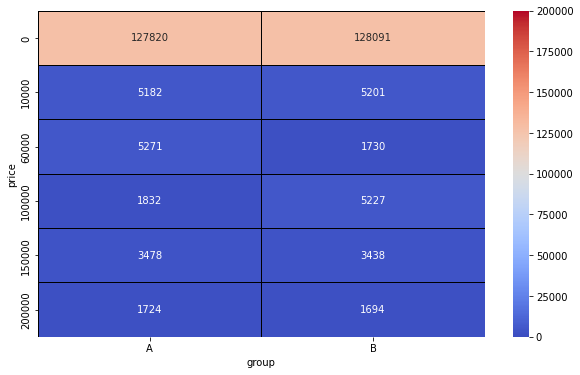

In [36]:
# Построение тепловой карты
fig = plt.subplots(figsize=(10,6))
sns.heatmap(pivot, annot=True, vmin=0, vmax=200000, center=100000, cmap='coolwarm', linewidth=1, linecolor='black', fmt='1g')

Сделайте выводы по построенной таблице. По каким турам покупательская способность участников группы А выше, чем участников группы B и наоборот?

*Покупательская способность участников группы А выше по турам стоимостью 60000, 150000, 200000 руб.; соответственно покупательская способность участников группы В выше для туров стоимостью 10000, 100000 руб.*

## **Задание 7.8.**

Настало время поговорить о стабилизации кумулятивных метрик во времени. Но прежде, чем перейти к кумулятивным метрикам, нам необходимо построить таблицу с ежедневными данными результатов проведения A/B-тестирования.

Сгруппируйте данные по дате и группе тестирования. В каждой группе вычислите количество посещений страницы, количество покупок и сумму покупок. 

Добавьте в таблицу информацию о ежедневной конверсии (ежедневное количество покупок / ежедневное количество посещений) в группе и ежедневном среднем чеке (ежедневная сумма покупок / ежедневное количество покупок)
* Чему равна конверсия 3 января 2021 года? Ответ приведите в процентах и округлите до сотых.

* Чему равен средний чек 3 января 2021 года? Ответ приведите в рублях и округлите до целого.

In [37]:
updated_data3 = updated_data.groupby(['date','group']).agg({
    'user_id': 'count',
    'purchase':'sum',
    'price': 'sum'
}).reset_index()

updated_data3['conversion'] = round(updated_data3['purchase'] / updated_data3['user_id'] * 100, 2)
updated_data3['mean_check'] = round(updated_data3['price'] / updated_data3['purchase'])

updated_data3.head()

,date,group,user_id,purchase,price,conversion,mean_check
0,2021-01-02,A,2854,359,29410000,12.58,81922.0
1,2021-01-02,B,2861,345,29660000,12.06,85971.0
2,2021-01-03,A,6596,748,62000000,11.34,82888.0
3,2021-01-03,B,6619,754,65960000,11.39,87480.0
4,2021-01-04,A,6566,799,64250000,12.17,80413.0


In [38]:
print(updated_data3.loc[(updated_data3['date']=='2021-01-03' ) & (updated_data3['group']=='A'), 'conversion'])
print(updated_data3.loc[(updated_data3['date']=='2021-01-03' ) & (updated_data3['group']=='B'), 'conversion'])
print(updated_data3.loc[(updated_data3['date']=='2021-01-03' ) & (updated_data3['group']=='A'), 'mean_check'])
print(updated_data3.loc[(updated_data3['date']=='2021-01-03' ) & (updated_data3['group']=='B'), 'mean_check'])

2    11.34
Name: conversion, dtype: float64
3    11.39
Name: conversion, dtype: float64
2    82888.0
Name: mean_check, dtype: float64
3    87480.0
Name: mean_check, dtype: float64


*По итогам расчета ежедневных данных получкены следующие результаты:   
конверсия 3 января 2021 года составила: в группе А - 11.34%, в группе В - 11.39%,    
средний чек 3 января 2021 года составил: в группе А - 82888 руб., в группе В - 87480 руб.*

## **Задание 7.9.** 

Добавьте в таблицу с ежедневными показателями кумулятивные признаки:
* кумулятивное количество посещений страницы
* кумулятивное количество покупок
* кумулятивную сумму покупок

Не забудьте при расчете кумулятивной суммы сгруппировать данные по группам. 

Вычислите кумулятивную конверсию и кумулятивный средний чек на основе полученных кумулятивных показателей. 

* Какая **кумулятивная** конверсия была в группе B на 20 января? Ответ приведите в процентах, округлив до сотых.
* Какой **кумулятивный** средний чек был в группе А на 12 января 2021 года? Ответ приведите в рублях, округлив до целых.

In [39]:
# вычисляем кумулятивные суммы:
updated_data3['cum_users_count'] = updated_data3.groupby(['group'])['user_id'].cumsum()
updated_data3['cum_purchase'] = updated_data3.groupby(['group'])['purchase'].cumsum()
updated_data3['cum_price'] = updated_data3.groupby(['group'])['price'].cumsum()

# вычисляем кумулятивную конверсию
updated_data3['cum_conversion'] = updated_data3['cum_purchase']/updated_data3['cum_users_count'] * 100

# вычисляем кумулятивный средний чек
updated_data3['cum_check'] = updated_data3['cum_price']/updated_data3['cum_purchase']

# вычисляем кумулятивную конверсию в группе В 20.01.2021 и кумулятивный средний чек в группе А 12.01.2021
print(round(updated_data3.loc[(updated_data3['date']=='2021-01-20' ) & (updated_data3['group']=='B'), 'cum_conversion'], 2))
print(round(updated_data3.loc[(updated_data3['date']=='2021-01-12' ) & (updated_data3['group']=='A'), 'cum_check']))

updated_data3.head()


37    11.9
Name: cum_conversion, dtype: float64
20    81492.0
Name: cum_check, dtype: float64


,date,group,user_id,purchase,price,conversion,mean_check,cum_users_count,cum_purchase,cum_price,cum_conversion,cum_check
0,2021-01-02,A,2854,359,29410000,12.58,81922.0,2854,359,29410000,12.578837,81922.005571
1,2021-01-02,B,2861,345,29660000,12.06,85971.0,2861,345,29660000,12.058721,85971.014493
2,2021-01-03,A,6596,748,62000000,11.34,82888.0,9450,1107,91410000,11.714286,82574.525745
3,2021-01-03,B,6619,754,65960000,11.39,87480.0,9480,1099,95620000,11.592827,87006.369427
4,2021-01-04,A,6566,799,64250000,12.17,80413.0,16016,1906,155660000,11.900599,81668.415530


Постройте кумулятивные графики конверсии и среднего чека в каждой группе по дням. Сделайте выводы. Можно ли назвать A/B-тест завершенным - стабилизировались ли значения метрик во времени? Как соотносятся кумулятивные показатели в каждой группе?

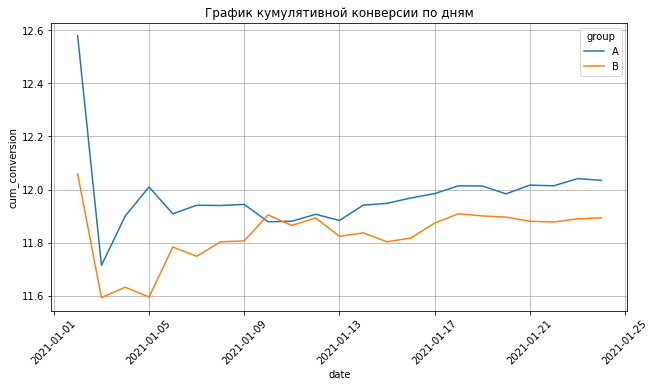

In [40]:
# создаём фигуру размером 8x4
fig = plt.figure(figsize=(8, 4))
# добавляем систему координат
ax = fig.add_axes([1, 1, 1, 1])
# строим lineplot для кумулятивной конверсии во времени в каждой группе
sns.lineplot(x='date', y='cum_conversion', data=updated_data3, hue='group', ax=ax)
# задаём подпись к графику
ax.set_title('График кумулятивной конверсии по дням')
# задаём поворот меток на оси абсцисс
ax.xaxis.set_tick_params(rotation = 45)
# задаём отображение сетки
ax.grid(True);

*Полученный график кумулятивный конверсий по дням указывает на то, что значения м етрик во времени стабилизировались и A/B-тест можно завершенным. При этом значения кумулятивной конверсии для группы А после стабилизации выше аналогичного показателя группы В.*

## **Задание 7.10.**

Настало время переходить к проверке статистической значимости разницы между метриками в группах. Начнем с конверсии.

Какой тест вы примените для проверки гипотезы о равенстве конверсий в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Конверсии в группах А и B равны; 
* $H_1$: Конверсия в группе А больше чем конверсия в группе B;

Вычислите p-value вашего теста для конверсий в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$=0.05. 

In [41]:
from statsmodels.stats.proportion import proportions_ztest
# сгруппируем данные по признаку группы и рассчитаем количество «успехов» (сумма по столбцу purchase) 
# и общее количество наблюдений (количество значений в столбце user_id для каждой группы.
updated_data4 = updated_data.groupby('group').agg({
    'user_id': 'count',
    'purchase':'sum'
}).reset_index()

display(updated_data4)

# нулевая и альтернативная гипотезы
H0 = 'Конверсии в группах А и B равны'
H1 = 'Конверсия в группе А выше, чем конверсия в группе B'
alpha = 0.05 # уровень значимости
# вычисляем значение p-value для z-теста для пропорций
_, p_value = proportions_ztest(
    count=updated_data4 ['purchase'], #число "успехов"
    nobs=updated_data4 ['user_id'], #общее число наблюдений
    alternative='larger',
)
# выводим результат на экран
print('p-value: ', round(p_value, 2))
# сравниваем полученное p-value с уровнем значимости
if (p_value < alpha): 
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

,group,user_id,purchase
0,A,145307,17487
1,B,145381,17290


p-value:  0.12
Принимаем нулевую гипотезу. Конверсии в группах А и B равны


Приведите свои выводы по результатам проведенного статистического теста. Есть ли статистическая разница между конверсиями в группах А и B?

*Результаты проведенного теста показали, что статистическая разница между конверсиями в группах А и В отсутствует.*

## **Задание 7.11.**
Убедитесь в своих рассуждениях, построив 95%-ый доверительный интервал для конверсий и разницы между ними. Используйте $z_{крит}$ в своих расчетах

Укажите нижнюю и верхнюю границы доверительных интервалов. Границы приведите в процентах и округлите до 2 знака после запятой. Например: нижняя граница 89.24%, верхняя граница 91.25%.

In [42]:
# построим доверительные интервалы конверсиий в группах
# фильтруем данные группы А
a_data = updated_data[updated_data['group'] == 'A']
# фильтруем данные группы B
b_data = updated_data[updated_data['group'] == 'B']

#  объявим функцию proportions_conf_interval(), которая будет возвращать границы доверительного интервала
def proportions_conf_interval(n, x_p, gamma=0.95):   
    alpha = 1 - gamma # уровень значимости
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (x_p * (1 - x_p) / n) ** 0.5 #погрешность
    lower_bound = x_p - eps # левая (нижняя) граница
    upper_bound = x_p + eps # правая (верхняя) граница
    # возвращаем кортеж из округлённых границ интервала
    return round(lower_bound * 100, 2), round(upper_bound * 100, 2)

# Теперь применим нашу функцию к данным группы А и группы B:
conf_interval_a = proportions_conf_interval(
n=a_data['user_id'].count(), # размер выборки
x_p=a_data['purchase'].mean() # выборочная пропорция
)
conf_interval_b = proportions_conf_interval(
n=b_data['user_id'].count(), # размер выборки
x_p=b_data['purchase'].mean() # выборочная пропорция
)
print('Доверительный интервал для конверсии группы А: {}'.format(conf_interval_a))
print('Доверительный интервал для конверсии группы B: {}'.format(conf_interval_b))


Доверительный интервал для конверсии группы А: (11.87, 12.2)
Доверительный интервал для конверсии группы B: (11.73, 12.06)


In [43]:
# построим доверительный интервал для разницы конверсий в группах
def diff_proportions_conf_interval(n, xp, gamma=0.95):
    alpha = 1 - gamma # уровень значимости
    diff = xp[1] - xp[0] # выборочная разница конверсий групп B и A
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (xp[0] * (1 - xp[0])/n[0] + xp[1] * (1 - xp[1])/n[1]) ** 0.5 # погрешность
    lower_bound = diff - eps # левая (нижняя) граница
    upper_bound = diff + eps # правая (верхняя) граница
    # возвращаем кортеж из округлённых границ интервала
    return round(lower_bound *100, 2), round(upper_bound * 100, 2)


# размеры выборок групп А и B
n = [a_data['user_id'].count(), b_data['user_id'].count()]
# выборочная пропорция групп A и B
xp = [a_data['purchase'].mean(), b_data['purchase'].mean()]
# строим доверительный интервал для разности конверсий
diff_inverval = diff_proportions_conf_interval(n, xp)
print('Доверительный интервал для разности конверсий: {}'.format(diff_inverval))

Доверительный интервал для разности конверсий: (-0.38, 0.09)


Проинтерпретируйте построенные доверительные интервалы для конверсий в группах. Есть ли перекрытие между доверительными интервалами для групп? Есть ли статистическая разница между конверсиями в группах А и B?

*Построенный доверительный интервал с 95 %-ой надёжностью говорит нам, что разница в конверсии между вариантом B и вариантом А лежит в интервале от -0.38 % до 0.09 %. То есть разница в конверсии с 95 %-ой надёжностью может быть как положительной, так и отрицательной. 
Отсюда можно сделать вывод, что статистической разницы в конверсии между вариантами А и B не существует, они являются равнозначными по данной метрике.*

## **Задание 7.12.**

Ранее мы построили таблицу с ежедневными показателями. Теперь она нам снова понадобится, так как нас интересует ежедневный средний чек.

Проверьте гипотезу о нормальности распределения ежедневного среднего чека в каждой из групп тестирования. 

* Какой тест вы примените  для проверки гипотезы о нормальности распределения ежедневного среднего чека?
* Как будут звучать нулевая и альтернативная гипотезы?
* Каковы результаты статистического теста с уровнем значимости $\alpha$ =0.05?

In [44]:
# для провкерки гипотезы о нормальности распределения ежедневного среднего чека будем использовать критерий Шапиро-Уилка, 
# пригодный для небольших выборок данных (до тысячи наблюдений)

from scipy.stats import shapiro
# нулевая и альтернативная гипотезы
H0 = 'Распределения в обеих группах нормальные'
H1 = 'Распределение в одной или обеих группах отлично от нормального'
alpha = 0.05 # уровень значимости
# вычисляем результат теста Шапиро-Уилка для выборок
shapiro_result_a = shapiro(updated_data3[updated_data3['group'] == 'A']['mean_check'])
shapiro_result_b = shapiro(updated_data3[updated_data3['group'] == 'B']['mean_check'])
print('p-value группы А', round(shapiro_result_a.pvalue, 2))
print('p-value группы B', round(shapiro_result_b.pvalue, 2))
# сравниваем полученное p-value с уровнем значимости
if shapiro_result_a.pvalue < alpha or shapiro_result_b.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value группы А 0.25
p-value группы B 0.09
Принимаем нулевую гипотезу. Распределения в обеих группах нормальные


*Результаты статистического теста свидетельствуют о нормальности распределения ежедневного среднего чека в обоих группах тестирования.*

## **Задание 7.13.**
Настало время сравнить варианты дизайна страницы по метрике среднего чека. 

Какой тест вы примените для проверки гипотезы о равенстве средних чеков по дням в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Ежедневные средние чеки в группах А и B равны; 
* $H_1$: Ежедневный средний чек в группе А меньше чем в группе B;

Вычислите p-value вашего теста для ежедневного среднего чека в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$ =0.05. 

In [45]:
# Итак, распределение в обеих группах нормальное, а значит, мы можем воспользоваться T-тестом для того, 
# чтобы сравнить средние чеки в группах.

from scipy.stats import ttest_ind
# нулевая и альтернативная гипотезы
H0 = 'Средний чек в группах одинаков'
H1 = 'Средний чек в группе А меньше, чем в группе B'
alpha = 0.05 #уровень значимости
#вычисляем результат T-теста для выборок
results = ttest_ind(
    a=updated_data3[updated_data3['group'] == 'A']['mean_check'],
    b=updated_data3[updated_data3['group'] == 'B']['mean_check'], 
    alternative='less'
)
print('p-value:', round(results.pvalue, 2))
 
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))
 

p-value: 0.0
Отвергаем нулевую гипотезу. Средний чек в группах одинаков
Альтернативная гипотеза. H1: Средний чек в группе А меньше, чем в группе B


 Приведите свои выводы по проведенному статистическому тесту. Есть ли статистическая разница между ежедневными средними чеками в группах А и B?

*Результаты Т-теста свидетельствуют, что имеется статистическая разница между ежедневными средними чеками в группах (средний чек в группе А меньше, чем в группе B)*

## **Задание 7.14.**

Постройте 95%-ый доверительный интервал для среднего чека в каждой группе. Так как выборка средних чеков небольшая, используйте  $t_{крит}$ в своих расчетах.

Укажите нижнюю границу доверительного интервала для истинного среднего чека каждой из групп. Ответ приведите в процентах и округлите до целого.

In [46]:
# определим размер выборки
updated_data3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46 entries, 0 to 45
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             46 non-null     datetime64[ns]
 1   group            46 non-null     object        
 2   user_id          46 non-null     int64         
 3   purchase         46 non-null     int64         
 4   price            46 non-null     int64         
 5   conversion       46 non-null     float64       
 6   mean_check       46 non-null     float64       
 7   cum_users_count  46 non-null     int64         
 8   cum_purchase     46 non-null     int64         
 9   cum_price        46 non-null     int64         
 10  cum_conversion   46 non-null     float64       
 11  cum_check        46 non-null     float64       
dtypes: datetime64[ns](1), float64(4), int64(6), object(1)
memory usage: 4.4+ KB


In [47]:
# таким образом всего в выборке 46 значений, 
# но с учетом разбиения на группы при расчете доверительных интервалов размер выборки n составит 23 значения

In [48]:
# построим 95% доверительный интервал для групп
from scipy.stats import t

a=updated_data3[updated_data3['group'] == 'A']['mean_check']
b=updated_data3[updated_data3['group'] == 'B']['mean_check']

n = 23 # размер выборки
k = n - 1 # число степеней свободы
x_mean_a = a.mean() # выборочное среднее группы А
x_std_a = a.std() # выборочное стандартное отклонение группы А
x_mean_b = b.mean() # выборочное среднее группы B
x_std_b = b.std() # выборочное стандартное отклонение группы B
gamma = 0.95 # уровень надёжности
alpha = 1 - gamma # уровень значимости

t_crit = -t.ppf(alpha/2, k) # t-критическое

eps_a = t_crit * x_std_a/(n ** 0.5) # погрешность для группы А
eps_b = t_crit * x_std_b/(n ** 0.5) # погрешность для группы B

lower_bound_a = x_mean_a - eps_a # левая (нижняя) граница для группы А
upper_bound_a = x_mean_a + eps_a # правая (верхняя) граница для группы А
lower_bound_b = x_mean_b - eps_b # левая (нижняя) граница для группы В
upper_bound_b = x_mean_b + eps_b # правая (верхняя) граница для группы В

# выводим значания округленных границ доверительных интервалов
confidence_interval_a = (round(lower_bound_a), round(upper_bound_a)) # создаём кортеж из округлённых границ интервала
print('Доверительный интервал для выборки А: {}'.format(confidence_interval_a)) 

confidence_interval_b = (round(lower_bound_b), round(upper_bound_b)) # создаём кортеж из округлённых границ интервала
print('Доверительный интервал для выборки B: {}'.format(confidence_interval_b)) 

Доверительный интервал для выборки А: (79630, 82308)
Доверительный интервал для выборки B: (87626, 89526)


Проинтерпретируйте построенные доверительные интервалы для ежедневных средних чеков в группах. Есть ли между ними пересечения?

*Рассчитанные доверительные интервалы не имеют пересечений, следовательно отсутствует вероятность, что истинное значение среднего чека в обеих группах может совпасть. То есть мы можем однозначно сказать, что есть разница в средних чеках групп.*

## **Сделайте общий вывод по результатам A/B-теста**

Какой варианта дизайна посадочной страницы является более эффективным в комплексе по метрикам конверсии и среднего чека и почему? 

*Результаты А/В теста свидетельствуют, что более эффективным в комплексе по метрикам конверсии и среднего чека является дизайн страницы тестируемый группой В, т.к. данная группа показала более высокое значение среднего чека, при этом отсутствует статистическая разница между конверсиями в группах.*